## Статистика и байесовские классификаторы.


In [ ]:
!pip install -q datasets
!pip install -q wandb
!pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
import os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3, palette="Set2")

import warnings

warnings.simplefilter("ignore")

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import load_files

from scipy.stats import ttest_rel

from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
)
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer, DistilBertTokenizer
import wandb

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import tarfile
import pickle


### Задача 1.   

**a).** Пусть $X_1,...,X_n$ выборка из некоторого распределения $\mathsf{P}$, причем ${\sf D} X_1=\sigma^2<+\infty$, и $\sigma$ неизвестно.
Рассмотрим оценку $S^2 = \overline{X^2}-\overline{X}^2$ дисперсии $\sigma^2$.

Докажите, что $S^2=\frac1n\sum\limits_{i=1}^n\left(X_i-\overline{X}\right)^2$.

**b).** Оценка $\widehat{\theta}$ называется несмещенной оценкой параметра $\theta$ если для любого $\theta \in \Theta$ выполнено $\mathsf{E}_\theta \widehat{\theta} = \theta$. Иначе говоря, какое бы ни оказалось истинное значение параметра $\theta$, рассматривая оценку $\widehat{\theta}$ в среднем будем получать именно $\theta$.

Является ли статистика $S^2$ несмещенной оценкой $\sigma^2$?

*Подсказка.* Посчитайте математическое ожидание случайной величины $S^2$. Используйте для этого известные вам свойства математического ожидания.

1. $\frac{1}{n} \sum_{i = 1}^{n}(X_i - \bar{X})^2 = \frac{1}{n} \sum_{i = 1}^{n}(X_i^2 - 2 * X_i \bar{X} + \bar{X}^2) = \bar{(X^2)} - 2 \bar{X} * \bar{X} + \bar{X}^2 = \bar{(X^2)} -  (\bar{X})^2$

2. $ES^2 = E ( \frac{1}{n} \sum X_i^2 -  (\frac{1}{n} \sum X_i)^2 = \frac{1}{n} \sum EX_i^2 - E(\frac{1}{n} \sum X_i)^2 = E X^2 - \frac{1}{n^2} E(\sum X_i) ^ 2$

$ E(\sum X_i)^2 = E (\sum X_i^2 + 2 \sum_{i != j} X_i X_j) = n E X^2 + n(n - 1) (EX_i)^2$

$ES^2 = E X^2 - \frac{(n E X^2 + n(n - 1) (EX)^2)}{n^2} = EX^2 (1 - \frac{1}{n}) - (EX)^2 (1 - \frac{1}{n}) = (1 - \frac{1}{n}) (EX^2 -(EX)^2)$

Исходя из всего выше написанного, ответ НЕТ, не являентся несмещенной относительно $\sigma^2$ так как иначе получилась бы $ES^2 = DX = (EX^2 -(EX)^2) != (1 - \frac{1}{n}) (EX^2 -(EX)^2)$ Но при $n \rightarrow \infty$ оценка все ближе и ближе к несмещенной.

 ---
### Задача 2.   
Пусть $X_1, ..., X_n$ &mdash; выборка из распределения $\mathcal{N}(0, \sigma^2)$. В качестве оценок $\sigma^2$ обычно используют $S^2$ или $\frac{n}{n-1}S^2$. Что можно сказать про их несмещенность?

**Ответ:**
1. Про $S^2$ можно сказать, что она не является несмещенной так как см первую задачу пункт б)
2.  $\frac{n}{n-1}S^2$ - является несмещенной, так как $E\frac{n}{n-1}S^2 = (EX^2 -(EX)^2) = DX = \sigma ^ 2$

**1.** Теперь проверьте это на практике. Для каждой из приведенных выше оценок $\widehat{\theta}$ выполните следующие действия.

* Вычислите $k = 500$ независимых оценок $\widehat{\theta}_1, ... , \widehat{\theta}_k$ по независимым выборкам $(X_1^1, ... , X_n^1), ... , (X_1^k, ... , X_n^k)$, сгенерированным из распределения $\mathcal{N}(0, \sigma^2)$. Для генерации выберите какое-то истинное значение $\sigma$. Далее вычислите среднее этих оценок, которое обозначим $\widetilde{\theta}$.

* Визуализируйте полученные значения, построив на **одном** графике точки $(\widehat{\theta}_1, $y$), ... , (\widehat{\theta}_k, y)$ и среднее оценок $(\widetilde{\theta}, y)$, где $y$ &mdash; произвольные различные (например, 0 и 1) координаты для двух различных типов оценок.

* Повторите действие три раза для $n \in \{10, 100, 500\}$. В итоге получится три графика для различных $n$, на каждом из которых изображено поведение двух типов оценок и их среднее.

Используйте приведенный ниже **шаблон** для визуализации значений.

**Внимание!** Следите за информативностью и наглядностью графиков. Например, пустых пространств должно быть как можно меньше, ничего не должно быть скомкано, вся нужная информация должна быть представлена. Посмотрите <a target="_blank" href="https://miptstats.github.io/courses/ad_fivt/lecture1_2.pdf">презентацию</a> по оформлению домашних заданий. **Если график чему-то не удовлетворяет, оценка будет снижена.**


**Решение:**


In [ ]:
size = 500
sigma = 2
def BuildEstimateGraphic(n):
  s = np.random.normal(0, sigma, (size, n))
  S = ((s - (s.mean(axis=1)).reshape(len(s), 1))**2).mean(axis=1)
  S_normed = S * n / (n - 1)

  S_mean = S.mean()
  S_normed_mean = S_normed.mean()

  plt.figure(figsize=(15,5))

  plt.scatter(S, np.zeros(len(S)),
            alpha=0.1, s=100, color='green', label=r'$ S^{2} $')

  plt.scatter(S_mean, 0, marker='*', s=200,
            color='g', edgecolors='black')

  plt.scatter(S_normed, np.zeros(len(S_normed)) + 1,
              alpha=0.1, s=100, color='red', label= r'$ \frac{n}{n-1}S^{2} $')

  plt.scatter(S_normed_mean, 1, marker='*', s=200,
              color='r', edgecolors='black')

  plt.vlines(S_mean, 0, 4, color='g')
  plt.vlines(S_normed_mean, 0, 4, color='r')

  plt.vlines(sigma ** 2, 0, 4, color='b', label=r' $\sigma^{2} $')
  plt.title(f'Размер выборки = {n}')
  plt.yticks([])
  plt.legend()


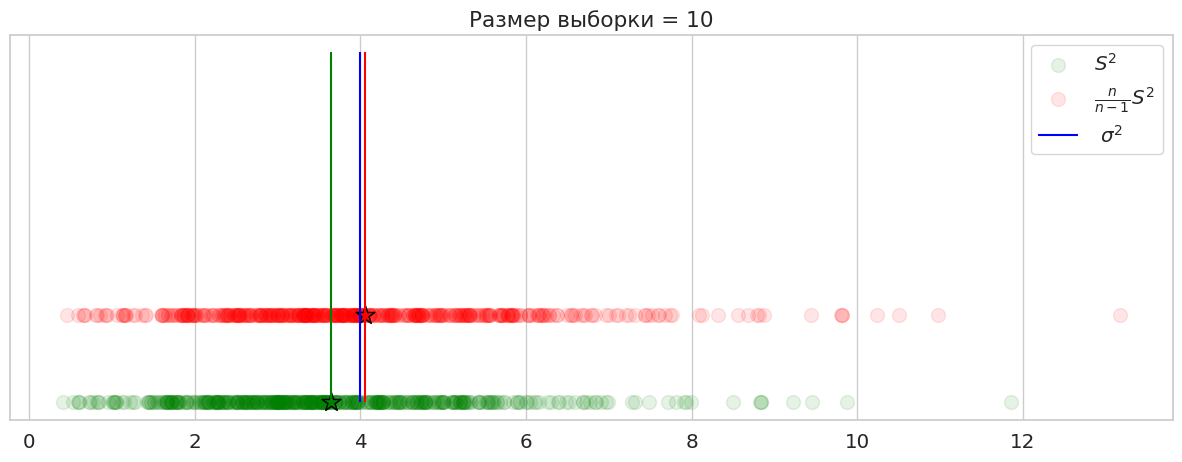

In [ ]:
BuildEstimateGraphic(10)

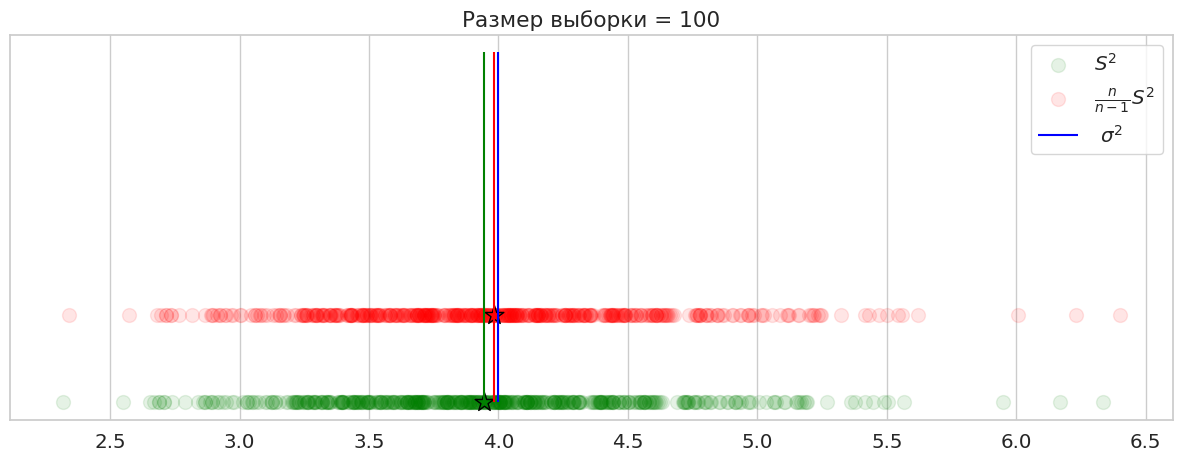

In [ ]:
BuildEstimateGraphic(100)

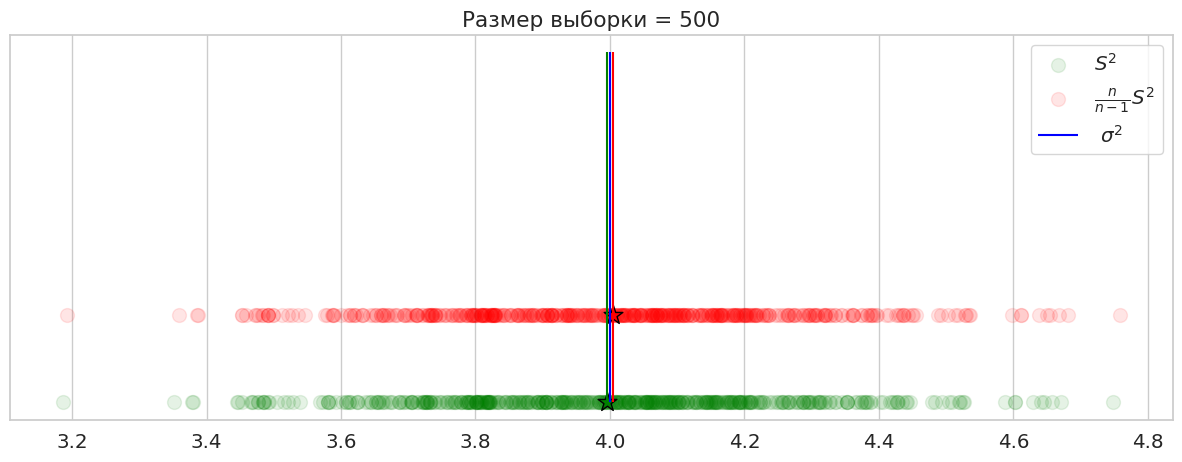

In [ ]:
BuildEstimateGraphic(500)

**2.** Изучим поведение среднего оценок из первого пункта при росте размера выборки. Постройте график зависимости $\widetilde{\theta}$ от $n$ для двух типов оценок. Для вычисления зависимости нужно один раз сгенерировать выборки из пункта 1 достаточно большого размера (не более 500) и посчитать оценки по подвыборкам, используя <a href="https://miptstats.github.io/courses/python/05_numpy.html#2.1-Математические-операции">функции</a> из `numpy`. Использовать циклы, а так же функции, разворачивающиеся в цикл (например, `np.vectorize`), запрещено.

**Решение:**

In [ ]:
size = 500
n = 500

s = np.random.normal(0, sigma, (size, n))
s_squared = s ** 2
array =  np.array([np.arange(1, s.shape[1] + 1)] * s.shape[0])

prefmean_s_squared = np.cumsum(s_squared, axis=1) / array
prefmean_s = np.cumsum(s, axis=1) / array
prefmean_s = prefmean_s ** 2

S_vs_n = prefmean_s_squared - prefmean_s

array = array[:, 1:]
n_div_n_minus_1 = array / (array - 1)

S_vs_n = S_vs_n[:, 1:]
S_normed_n = S_vs_n * n_div_n_minus_1

meanS = np.mean(S_vs_n, axis=0)
meanNormedS = np.mean(S_normed_n, axis=0)

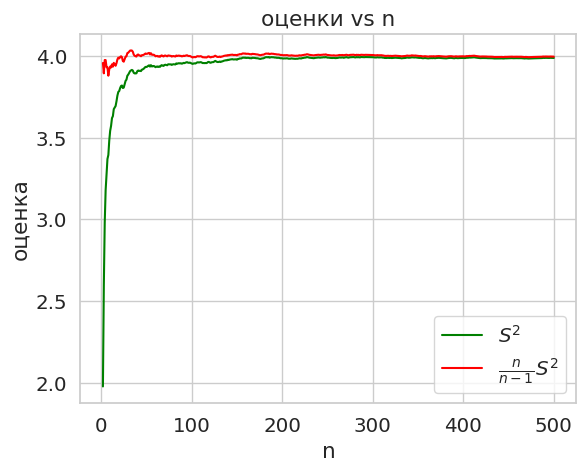

In [ ]:
x = np.array([np.arange(2, s.shape[1] + 1)]).reshape(s.shape[1] - 1)
plt.plot(x, meanS, color='green', label=r'$ S^{2} $')
plt.plot(x, meanNormedS, color='red', label=r'$ \frac{n}{n-1} S^{2} $')
plt.legend()
plt.xlabel('n')
plt.ylabel('оценка')
plt.title('оценки vs n')
plt.show()

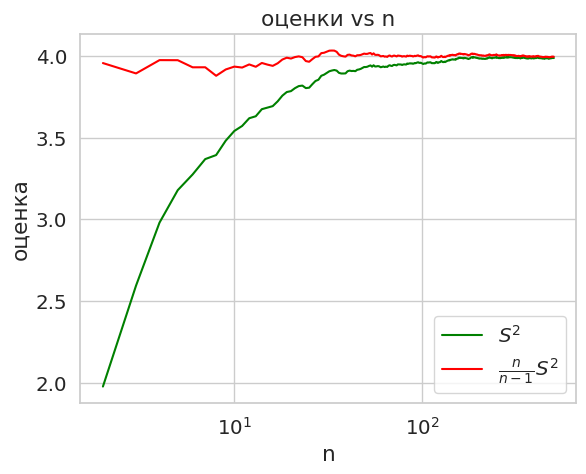

In [ ]:
x = np.array([np.arange(2, s.shape[1] + 1)]).reshape(s.shape[1] - 1)
plt.plot(x, meanS, color='green', label=r'$ S^{2} $')
plt.plot(x, meanNormedS, color='red', label=r'$ \frac{n}{n-1} S^{2} $')

plt.legend()
plt.xscale('log')
plt.xlabel('n')
plt.ylabel('оценка')
plt.title('оценки vs n')
plt.show()

Сделайте вывод о том, что такое свойство несмещенности. Подтверждают ли сделанные эксперименты полученное в теоретических задачах свойство несмещенности (или отсутствие этого свойства) данных оценок?

*Для ПМФ:* поясните, почему в лабораторных по физике при оценке погрешности иногда используют $n-1$ в знаменателе, а не $n$.

*Замечание.* Для ответа на вопрос достаточно понимания текущего материала, ничего из физики знать не требуется.

**Вывод:** <br>
1. Свойство несмещенности отвечает за отклонение оценки от истинного значения, если оценка несмещенная, то её матож будет равен самому значению, если же нет, то при разных обстоятельствах, он поразному откланяется от истинного значения. Например в нашем примере $S^2$ отклоняется от $\sigma^{2}$, но все же стремится к истинному значению, при $n \rightarrow \infty$.
2. Как мы и предположили в начале задаче, в теоритической части оценка $S^2$ - не является несмещенной. А оценка $\frac{n}{n-1}S^{2}$ - является несмещенной. Это подтвердилось эксперементом. На графики мы можем видеть довольно большое отклонение первой оценки от истинного значения, и довольно малое отклонение второй от истинного значения.
3. По мимо всего прочего мы убедились, что при $n \rightarrow \infty$ первая оценка тоже стремится к истинному значению.
4. При том довольно хорошо наблюдается стремление обеих оценок к истиному значению при увеличении n, что показывает график.

In [ ]:
...

*Замечание.* Проведенные эксперименты позволяют сделать вывод только о поведении среднего значения оценки, но ничего не говорят о том, насколько велик их разброс относительно среднего.

---
### Задача 3.

Рассмотрим задачу построения системы, автоматически классифицирующей поступающие новостные сюжеты на несколько заранее заданных категорий.

![news.jpg](attachment:news.jpg)

`

Перед выполнением задачи обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/bayes_classification.html">ноутбук</a> с занятия по классификации.

---

С помощью кода ниже загрузите встроенные в `sklearn` <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups">данные</a>, в которых представлены различные новостные сюжеты, разделенные на 20 тематических групп.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/newsgroup_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/newsgroup_test.csv')

data_train = data_train.dropna()
data_test = data_test.dropna()

data_train = data_train.sample(frac = 1)
data_test = data_test.sample(frac = 1)

data_train.head()

,Unnamed: 0,text,target,title,date
93,1659,"\n\tI'm no mustang head, but don't the early o...",7,rec.autos,2024-04-29 22:55:23.866010
3892,7490,I'm posting this for a friend that runs a BBS....,3,comp.sys.ibm.pc.hardware,2024-04-29 22:55:23.866010
10510,6238,\nTRANSLATION- you minorities stay in predesig...,18,talk.politics.misc,2024-04-29 22:55:23.866010
10715,11233,"# ## Face it, Clayton, he was not found guilty...",18,talk.politics.misc,2024-04-29 22:55:23.866010
6827,2228,: \tDoes anybody out there know how the hand h...,12,sci.electronics,2024-04-29 22:55:23.866010


Посмотрим на какое-нибудь сообщение

In [ ]:
print(data_train['text'][21])


On the cars mentioned - 3 series from the late 80's the "electronic"
odometer is really a mechanical drum type odometer, that is driven
by pulses from a speed sensor on the rear axle.  These pulses are 
converted into mechanical pulses that turn the odometer - and speedometer.
No way changing or erasing an eprom is going to change the mileage
reading.  It also means the odometer is just as easy (or hard) to
change as any other mechanical odometer.

On the other hand it is a bit easier to disconnect the speed sensor
and run the car with no speedometer or odometer reading...a simple
switch will do the job.  It also will disable the speed limiter,
which will enable the car to reach it's full speed.  ;-)




Индекс тематической группы для каждого сообщения

In [ ]:
data_train['target']

93        7
3892      3
10510    18
10715    18
6827     12
         ..
8351     10
3911      3
6377      0
10366    18
1130      4
Name: target, Length: 11096, dtype: int64

Названия тематических групп

In [ ]:
data_train['title']

93                      rec.autos
3892     comp.sys.ibm.pc.hardware
10510          talk.politics.misc
10715          talk.politics.misc
6827              sci.electronics
                   ...           
8351             rec.sport.hockey
3911     comp.sys.ibm.pc.hardware
6377                  alt.atheism
10366          talk.politics.misc
1130        comp.sys.mac.hardware
Name: title, Length: 11096, dtype: object

Разделите данные на обучающую, валидационную и тестовую части

In [ ]:
len_test = len(data_test) // 2

data_valid = data_test[len_test:]
data_test = data_test[:len_test]

Прежде чем приступать к построению сложных систем всегда стоит выбрать простой бейзлайн &mdash; модель, которую вы можете получить относительно быстро, и она не занимает много ресурсов.

В качестве бейзлайна рассмотрим простую модель, обученную на представлении текстов в виде мешка слов (bag of words). Мы можем обучить два известных нам классификатора:
* метод ближайших соседей,
* наивный байесовский классификатор.

Подумайте, почему метод ближайших соседей не подходит для решения данной задачи.

Хочется отметить, что применение KNN в данной задаче не челесообразно, так как идет работа с текстом, а следовательно, пространство наших признаков, сильно разрежено, и близасть как таковая отсутствует. Кроме того, в силу большой размерности простравнства признаков, будет действовать проклятие размерностей. Можно конечно воспоьзоваться PCA и тогда скорее всего мы улучшим результат, но все же первый пунк останется в силе.

In [ ]:
counts = pd.value_counts(data_train['title'], sort=True)
counts

title
soc.religion.christian      594
comp.windows.x              592
rec.sport.hockey            590
rec.motorcycles             587
comp.sys.ibm.pc.hardware    584
sci.med                     583
sci.crypt                   583
misc.forsale                581
rec.sport.baseball          581
sci.space                   580
sci.electronics             577
comp.os.ms-windows.misc     576
comp.graphics               572
rec.autos                   569
comp.sys.mac.hardware       565
talk.politics.mideast       552
talk.politics.guns          537
alt.atheism                 472
talk.politics.misc          458
talk.religion.misc          363
Name: count, dtype: int64

In [ ]:
print(f'кол-во классов {len(counts)}')

кол-во классов 20


<Axes: xlabel='title'>

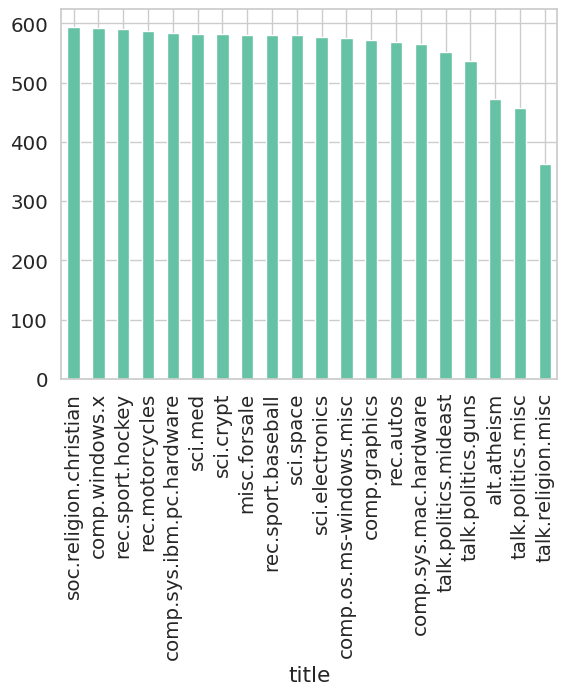

In [ ]:
counts.plot(kind="bar")

In [ ]:
vectorizer = CountVectorizer(min_df=0.01, max_df=0.05)
vec_data_train = vectorizer.fit_transform(data_train['text']).toarray()
vec_data_test = vectorizer.transform(data_test['text']).toarray()

print(len(vectorizer.get_feature_names_out()))
print(vectorizer.get_feature_names_out()[:100])

1174
['00' '000' '100' '11' '12' '13' '14' '15' '150' '16' '17' '18' '19'
 '1990' '1992' '1993' '20' '200' '21' '22' '23' '24' '25' '250' '26' '27'
 '28' '29' '2nd' '30' '300' '31' '32' '33' '34' '35' '40' '42' '44' '45'
 '486' '50' '500' '60' '70' '75' '80' '800' '90' '92' '93' 'ability'
 'above' 'absolutely' 'ac' 'accept' 'accepted' 'access' 'according'
 'account' 'across' 'act' 'action' 'actions' 'acts' 'actual' 'add' 'added'
 'addition' 'additional' 'address' 'administration' 'admit' 'advance'
 'advice' 'age' 'ago' 'agree' 'air' 'al' 'algorithm' 'allow' 'allowed'
 'allows' 'almost' 'alone' 'along' 'already' 'alt' 'although' 'always'
 'america' 'american' 'americans' 'among' 'amount' 'analysis' 'answer'
 'answers' 'anti']


Обучите наивный байесовский классификатор, подобрав также для него оптимальные гиперпараметры. В качестве гиперпараметров можно рассмотреть, например, параметры мешка слов.

Для выполнения этой процедуры зафиксируйте несколько комбинаций значений гиперпараметров, для каждой из них обучите модель по обучающей части выборки и посчитайте качество (точность классификации) на валидационной части. Выберите классификатор, дающий максимальную точность.

In [ ]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, data_train.target)

MultinomialNB()

Посчитайте качество на тестовой выборке.

In [ ]:
multinomial_predictions = multinomial_nb.predict(vec_data_test)
print(
    f"Точность: {accuracy_score(data_test.target, multinomial_predictions) :.3}"
)

Точность: 0.469


Так как у нас в тексте слишком много цифр, которые не несут особого смысла, то просто удалим их и проверим как изменится точность нашего байесовского классификатора


In [ ]:
data_train.replace('\d+', '', regex=True, inplace=True)
data_test.replace('\d+', '', regex=True, inplace=True)
data_valid.replace('\d+', '', regex=True, inplace=True)

vectorizer = CountVectorizer(min_df=0.01, max_df=0.05)
vec_data_train = vectorizer.fit_transform(data_train['text']).toarray()
vec_data_test = vectorizer.transform(data_test['text']).toarray()

print(len(vectorizer.get_feature_names_out()))
print(vectorizer.get_feature_names_out()[:100])

multinomial_nb = MultinomialNB()
multinomial_nb.fit(vec_data_train, data_train.target)

multinomial_predictions = multinomial_nb.predict(vec_data_test)
print(
    f"Точность: {accuracy_score(data_test.target, multinomial_predictions) :.3}"
)

1135
['ability' 'above' 'absolutely' 'ac' 'accept' 'accepted' 'access'
 'according' 'account' 'across' 'act' 'action' 'actions' 'acts' 'actual'
 'add' 'added' 'addition' 'additional' 'address' 'administration' 'admit'
 'advance' 'advice' 'age' 'ago' 'agree' 'air' 'al' 'algorithm' 'allow'
 'allowed' 'allows' 'almost' 'alone' 'along' 'already' 'alt' 'although'
 'always' 'america' 'american' 'americans' 'among' 'amount' 'analysis'
 'answer' 'answers' 'anti' 'anybody' 'anyway' 'anywhere' 'apparently'
 'appear' 'appears' 'apple' 'application' 'applications' 'apply'
 'appreciate' 'appreciated' 'approach' 'appropriate' 'apr' 'april'
 'archive' 'area' 'areas' 'aren' 'argument' 'arguments' 'arms' 'army'
 'article' 'articles' 'ask' 'asked' 'asking' 'assume' 'assuming' 'attack'
 'attempt' 'attention' 'author' 'authority' 'average' 'avoid' 'aware'
 'away' 'background' 'bad' 'banks' 'base' 'baseball' 'based' 'basic'
 'basically' 'basis' 'became' 'become']
Точность: 0.488


Подберем теперь оптимальные параметры: <br>
Для этого используем `data_valid`

In [ ]:
def Validate(min_df=0.01, max_df=0.05, max_features=100):
  vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features)
  vec_data_train = vectorizer.fit_transform(data_train['text']).toarray()
  vec_data_valid = vectorizer.transform(data_valid['text']).toarray()

  multinomial_nb = MultinomialNB()
  multinomial_nb.fit(vec_data_train, data_train.target)

  multinomial_predictions = multinomial_nb.predict(vec_data_valid)
  return accuracy_score(data_valid.target, multinomial_predictions)

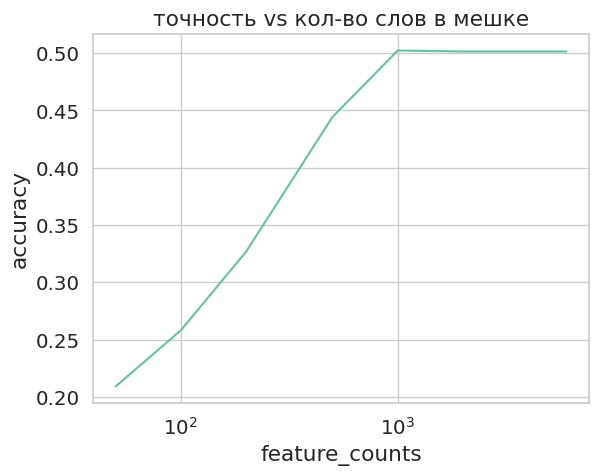

In [ ]:
feature_counts = [50, 100, 200, 500, 1000, 2000, 4000, 6000]
accs_vs_cnt = []

for feat_cnt in feature_counts:
  accs_vs_cnt.append(Validate(max_features=feat_cnt))

plt.plot(feature_counts, accs_vs_cnt)
plt.xlabel('feature_counts')
plt.ylabel('accuracy')
plt.xscale('log')
plt.title('точность vs кол-во слов в мешке')
plt.show()

Оптимально значение параметра `max_features` ~ 1000 <br>
Подбираем `min_df` без ограничения `max_df` (=1.0)

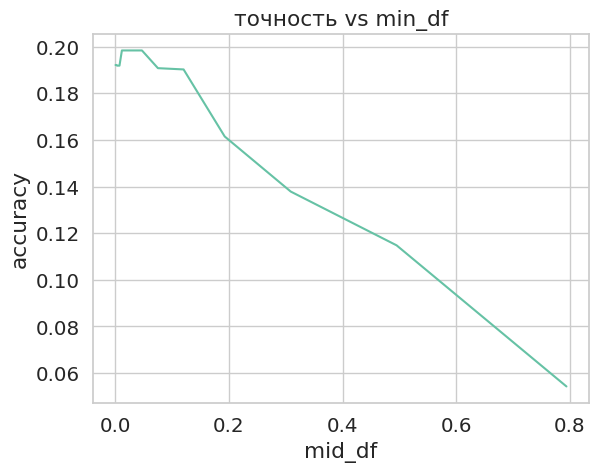

In [ ]:
min_dfs = np.logspace(-4, -0.1, num = 20)
accs_vs_mindf = []

for mid_df in min_dfs:
  accs_vs_mindf.append(Validate(min_df=mid_df, max_df=1.0))

plt.plot(min_dfs, accs_vs_mindf)
plt.xlabel('mid_df')
plt.ylabel('accuracy')
plt.title('точность vs min_df')

plt.show()

Мы видемь, что после 0.05, точность только уменьшается, тоэтому оставим оптмальное значение ~ `0.0025`
Теперь аналогично `max_df` в не завсимости от `mid_df` (=0.0)

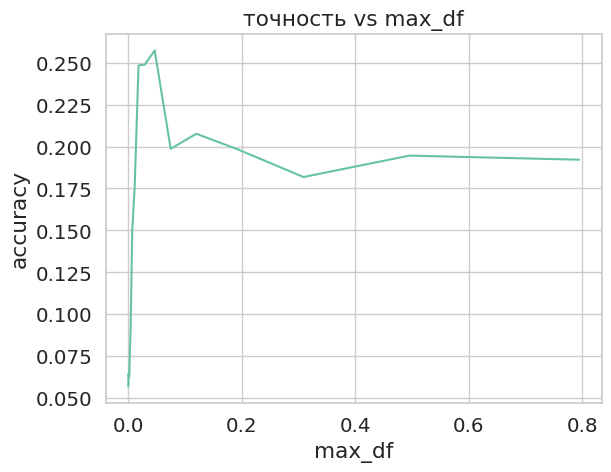

In [ ]:
max_dfs = np.logspace(-4, 0, num = 20)
accs_vs_maxdf = []

for max_df in max_dfs:
  accs_vs_maxdf.append(Validate(min_df=0.0, max_df=max_df))

plt.plot(min_dfs, accs_vs_maxdf)
plt.xlabel('max_df')
plt.ylabel('accuracy')
plt.title('точность vs max_df')
plt.show()

оптимум `max_df` ~ 0.05 <br>
Обучим модель с оптиальными параметрами

In [ ]:
opt_min_df = 0.0025
opt_max_df = 0.05
opt_feature_cnt = 1000

res_acc_bais = Validate(min_df=opt_min_df, max_df=opt_max_df, max_features=opt_feature_cnt)
print(f'точность оптимально модели: {res_acc_bais :.3}')

точность оптимально модели: 0.512


Выберите некоторую нейросеть для классификации текстов. Вы можете выбрать готовую нейросеть и дообучить ее на рассматриваемых данных, как это сделано на <a href="https://miptstats.github.io/courses/ad_fivt/bayes_classification.html">семинаре</a>, так и самостоятельно написать нейросеть.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-2-v2")
model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/ms-marco-TinyBERT-L-2-v2", num_labels = 20, ignore_mismatched_sizes=True)

tokenizer_config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cross-encoder/ms-marco-TinyBERT-L-2-v2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1, 128]) in the checkpoint and torch.Size([20, 128]) in the model instantiated
- classifier.bias: found shape torch.Size([1]) in the checkpoint and torch.Size([20]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df = pd.DataFrame({'data': data_train['text'], 'target': data_train['target']})
test_df = pd.DataFrame({'data': data_test['text'], 'target': data_test['target']})
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.columns = ['text', 'label']
test_df.columns = ['text', 'label']
valid_df.columns = ['text', 'label']

train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512, return_tensors='pt')

train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
tokenized_train = train_dataset.map(preprocess_function, batched=True, batch_size=256)
tokenized_train

Map:   0%|          | 0/8876 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8876
})

In [ ]:
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)
tokenized_test = test_dataset.map(preprocess_function, batched=True, batch_size=256)
tokenized_test

Map:   0%|          | 0/3685 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3685
})

In [ ]:
def compute_metrics(eval_pred):
    """
    Функция для вычисления метрик на валидации, подается в Trainer

    :param eval_pred: tuple из двух элементов: предсказания модели (логиты) и истинные метки

    :return: словарь со значением метрики accuracy
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, predictions)}

os.environ["WANDB_PROJECT"] = "News classification"

training_args = TrainingArguments(
    output_dir="news_classifier",
    learning_rate=1e-04,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_strategy="epoch",
    logging_steps=100,
    evaluation_strategy="epoch",
    eval_steps=500,
    report_to="wandb",
    gradient_accumulation_steps=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,2.821900,2.531776,0.303664
2,2.332700,2.138243,0.461330
3,1.951900,1.855374,0.539213
4,1.656900,1.678683,0.576391
5,1.437500,1.548728,0.597829
6,1.262400,1.451854,0.618182
7,1.122700,1.392697,0.623881
8,0.999600,1.350687,0.631750
9,0.901300,1.315636,0.643148
10,0.810100,1.296292,0.646133


TrainOutput(global_step=2780, training_loss=1.0431276060694412, metrics={'train_runtime': 549.6027, 'train_samples_per_second': 322.997, 'train_steps_per_second': 5.058, 'total_flos': 226803142164480.0, 'train_loss': 1.0431276060694412, 'epoch': 20.0})

In [ ]:
tbert_logits = trainer.predict(tokenized_test).predictions
tbert_predictions = np.argmax(tbert_logits, axis=1)

res_acc_nn = np.mean(data_test['target'] == tbert_predictions)
print(f'{res_acc_nn:.3}')

0.648


Сравните качество моделей на тестовой выборке. Можно ли с уверенностью утверждать, что одна из моделей лучше другой?

In [ ]:
print(f'neural network final accuracy: {res_acc_nn : .3}')
print('VS')
print(f'bais clasifier final accuracy: {res_acc_bais : .3}')

neural network final accuracy:  0.648
VS
bais clasifier final accuracy:  0.512


Сделайте выводы. <br>

1. Сперва хочется отметить, что мы применяли наивный баисовский классификатор, в предположеии, что у нас все feauture независимы, но это не так! И, не смотря на это, он дал довольно не плохую оценку. Всего мы имеем 20 классов, а значит, если бы мы генерировали клас рандомно, то наша точность была бы 1/20 = 0.05, а с помощью наивного баисовского классификатора мы достигли оченки в 10 раз лучше.
2. Мы еще раз на практике убидились в важности подбора гиперпарамптров и валидационной выборки. Благодаря этомы мы неплохо улучшили скор.
3. Коечно же нельзя не заметить, что Нейронная сеть справляется лучше, но во-первых, она заранее предобучена, что экономит кучу времени (не смотря на это, она все раво очень долго доучивалась). Во-вторых, для нее требуется довольно не тривиальная обработка данных.
4. По итгам, хочется отметить, что наивный баисовский классификатор, даже при изначальных гиперпараметрах давал довольно не плохой результат, при том тратил очень мало время на обучение и не требовал тяжелой предобработки данных. Тем самым он является отличным инструментом для создания base-line.

---
### Задача 4.

Пусть $\mathscr{X} = \mathbb{R}^d$ — пространство признаков, $\mathscr{Y} = \{0, 1\}$ — множество классов. Рассматривается квадратичный дискриминантный анализ (QDA), в котором условное распределение $X$ при условии $Y=k$ равно $\mathcal{N}(a_k, \Sigma_k)$. Разделяющей поверхностью между классами $k$ и $\ell$ называется множество точек пространства признаков, для которых вероятность этих двух классов одинакова.

**1.**
Покажите, что в модели QDA разделяющие поверхности в общем случае квадратичны, а в LDA &mdash; линейны между любыми двумя классами.

*Примечание.* В LDA предполагается $\Sigma_1 = ... = \Sigma_k$.

**2.**
Рассмотрим квадратичный дискриминантный анализ при $d=2$. Приведите примеры таких параметров $a_k, \Sigma_k$ и вероятностей $\mathsf{P}(Y = k)$, при которых разделяющая поверхность является
* гиперболой;
* параболой;
* двумя параллельными прямыми;
* двумя пересекающимися прямыми.

*Примечание.* Можно подобрать выборку, посчитать оценки со страшными числами. Но еще лучше &mdash; немного подумать и привести пример с "красивыми" числами без какого-либо подбора выборки. В данном случае это довольно просто, а также позволяет лучше разобраться в параметрах многомерного нормального распределения.
